Error processing .ipynb_checkpoints: [Errno 13] Permission denied: 'Flickr8k_Dataset/1\\.ipynb_checkpoints'
1/1 [==============================] - 0s 128ms/step
Epoch 1/30
225/225 [==============================] - 62s 244ms/step - loss: 5.2457 - accuracy: 0.1853 - val_loss: 4.7543 - val_accuracy: 0.2451
Epoch 2/30
225/225 [==============================] - 50s 222ms/step - loss: 3.8202 - accuracy: 0.2998 - val_loss: 4.4238 - val_accuracy: 0.2914
Epoch 3/30
225/225 [==============================] - 45s 201ms/step - loss: 3.1163 - accuracy: 0.3611 - val_loss: 4.3391 - val_accuracy: 0.3061
Epoch 4/30
225/225 [==============================] - 102s 454ms/step - loss: 2.6166 - accuracy: 0.4121 - val_loss: 4.3659 - val_accuracy: 0.3034
Epoch 5/30
225/225 [==============================] - 76s 336ms/step - loss: 2.2445 - accuracy: 0.4481 - val_loss: 4.5174 - val_accuracy: 0.3028
Epoch 6/30
225/225 [==============================] - 49s 216ms/step - loss: 1.9641 - accuracy: 0.4859 - val_loss

c:\Users\aashi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


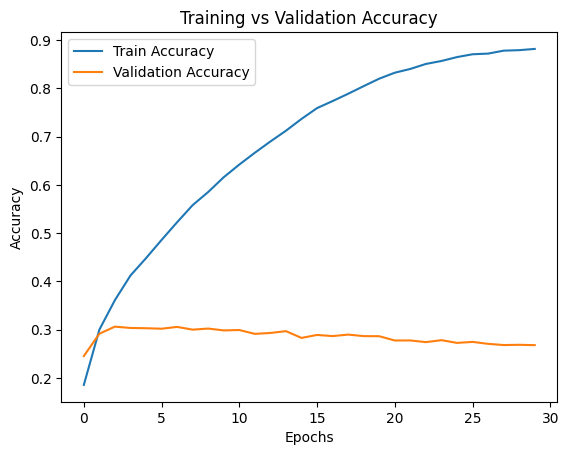

1/1 [==============================] - 0s 26ms/step
BLEU Score for 1000268201_693b08cb0e.jpg: 0.8948


0.8948393168143697

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from nltk.translate.bleu_score import sentence_bleu

FOLDER_PATH = "Flickr8k_Dataset/1"
CAPTIONS_FILE = "Flickr8k_text/Flickr8k.token.txt"

def load_captions(filepath):
    captions_dict = {}
    with open(filepath, 'r', encoding="utf-8") as file:
        for line in file:
            image_id, caption = line.strip().split("\t")
            image_id = image_id.split("#")[0]  # Remove # and number
            caption = caption.lower()
            captions_dict.setdefault(image_id, []).append("startseq " + caption + " endseq")
    return captions_dict

captions_dict = load_captions(CAPTIONS_FILE)

model_incep = InceptionV3(weights='imagenet')
model_incep = Model(model_incep.input, model_incep.layers[-2].output)

def extract_features(image_path):
    img = Image.open(image_path).resize((299, 299))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model_incep.predict(img_array)
    return features.squeeze() 

image_features = {}
image_list = os.listdir(FOLDER_PATH)[:600]  

for img_name in image_list:
    img_path = os.path.join(FOLDER_PATH, img_name)
    try:
        image_features[img_name] = extract_features(img_path)
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

pickle.dump(image_features, open("image_features.pkl", "wb"))

tokenizer = Tokenizer()
tokenizer.fit_on_texts([cap for caps in captions_dict.values() for cap in caps])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

def caption_to_seq(caption):
    return [tokenizer.word_index[word] for word in caption.split() if word in tokenizer.word_index]

sequences = []
next_words = []
image_keys = []

for img_name, captions in captions_dict.items():
    if img_name not in image_features:  
        continue
    for caption in captions:
        seq = caption_to_seq(caption)
        for i in range(1, len(seq)):
            sequences.append(seq[:i])
            next_words.append(seq[i])
            image_keys.append(img_name)

max_len = max(len(seq) for seq in sequences)
X_seq = pad_sequences(sequences, maxlen=max_len, padding='post')
y = to_categorical(next_words, num_classes=vocab_size)

# Build the Captioning Model
input_img = tf.keras.layers.Input(shape=(2048,))
dropout1 = Dropout(0.5)(input_img)
dense1 = Dense(256, activation='relu')(dropout1)

input_txt = tf.keras.layers.Input(shape=(max_len,))
embed = Embedding(vocab_size, 256, mask_zero=True)(input_txt)
lstm = LSTM(256)(embed)

comb = tf.keras.layers.add([dense1, lstm])
dense2 = Dense(vocab_size, activation='softmax')(comb)

model = Model(inputs=[input_img, input_txt], outputs=dense2)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model with validation split
image_inputs = np.array([image_features[img] for img in image_keys])

history = model.fit(
    [image_inputs, X_seq], y,
    epochs=30,
    batch_size=64,
    validation_split=0.6,  # 20% data for validation
    verbose=1
)

# Save trained model
model.save("image_caption_model.h5")

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

def generate_caption(image_path):
    features = extract_features(image_path)
    caption = 'startseq'
    for _ in range(max_len):
        seq = pad_sequences([caption_to_seq(caption)], maxlen=max_len, padding='post')
        pred = np.argmax(model.predict([features.reshape(1, 2048), seq]))
        word = tokenizer.index_word.get(pred, '')
        if word == 'endseq' or word == '':
            break
        caption += ' ' + word
    return caption.replace('startseq', '').replace('endseq', '').strip()

def evaluate_bleu(image_name):
    if image_name not in captions_dict or image_name not in image_features:
        print("Image not found in dataset.")
        return None
    
    reference_captions = [cap.split() for cap in captions_dict[image_name]]
    predicted_caption = generate_caption(os.path.join(FOLDER_PATH, image_name)).split()

    bleu_score = sentence_bleu(reference_captions, predicted_caption)
    print(f"BLEU Score for {image_name}: {bleu_score:.4f}")
    return bleu_score

test_img_name = list(image_features.keys())[0]  # Pick the first image in the dataset
evaluate_bleu(test_img_name)


1/1 [==============================] - 0s 29ms/step


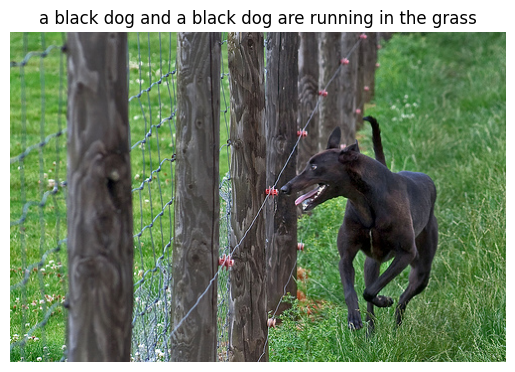

In [23]:
# Test on a sample image
test_image = "E:/DMPM_C2P2/PHASE_1/ashirwaddmpm/Flickr8k_Dataset/1/3693961165_9d6c333d5b.jpg"
plt.imshow(Image.open(test_image))
plt.axis('off')
plt.title(generate_caption(test_image))
plt.show()